<a href="https://colab.research.google.com/github/jvpalhares/IA353-vonzuben-pc2-2023.1/blob/main/PC2_Ativ8_GAN_FASHION_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Notebook #8**
## Generative Adversarial Networks for the MNIST dataset.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** João Victor Palhares Barbosa


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#!pip install keras

In [9]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import matplotlib.image as mpimg

In [10]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % 100 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/drive/MyDrive/Colab Notebooks/ativ8_GAN_FASHION_MNIST/output/q9_images/%d.png" % epoch) # Please, define the working directory appropriately
        plt.close()

In [11]:
%%time
gan = GAN()
gan.train(epochs=30001, batch_size=32, sample_interval=1000)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
25100 [D loss: 0.724406, acc.: 53.12%] [G loss: 0.939697]
1/1 [==============================] - 0s 29ms/step
25200 [D loss: 0.678767, acc.: 57.81%] [G loss: 0.989832]
1/1 [==============================] - 0s 34ms/step
25300 [D loss: 0.644222, acc.: 64.06%] [G loss: 0.943000]
1/1 [==============================] - 0s 37ms/step
25400 [D loss: 0.632211, acc.: 60.94%] [G loss: 0.951183]
1/1 [==============================] - 0s 25ms/step
25500 [D loss: 0.647406, acc.: 57.81%] [G loss: 0.909354]
1/1 [==============================] - 0s 23ms/step
25600 [D loss: 0.687742, acc.: 62.50%] [G loss: 1.014700]
1/1 [==============================] - 0s 23ms/step
25700 [D loss: 0.636876, acc.: 62.50%] [G loss: 1.123102]
1/1 [==============================] - 0s 24ms/step
25800 [D loss: 0.654418, acc.: 65.62%] [G loss: 0.936558]
1/1 [==============================] - 0s 35ms/step
25900 [D loss: 0.

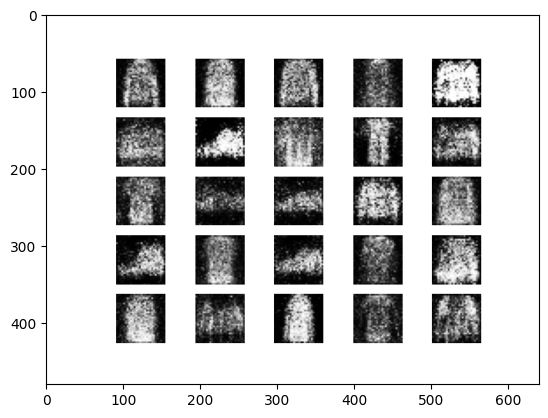

In [12]:
image = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/ativ8_GAN_FASHION_MNIST/output/q9_images/1000.png")
plt.imshow(image)
plt.show()

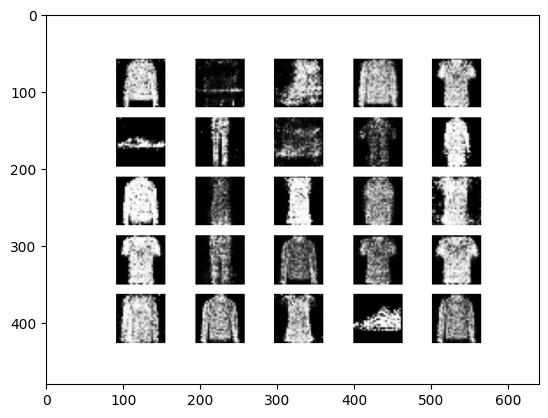

In [13]:
image = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/ativ8_GAN_FASHION_MNIST/output/q9_images/10000.png")
plt.imshow(image)
plt.show()

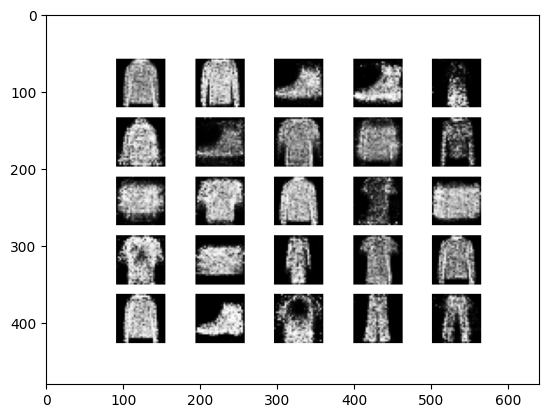

In [14]:
image = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/ativ8_GAN_FASHION_MNIST/output/q9_images/20000.png")
plt.imshow(image)
plt.show()

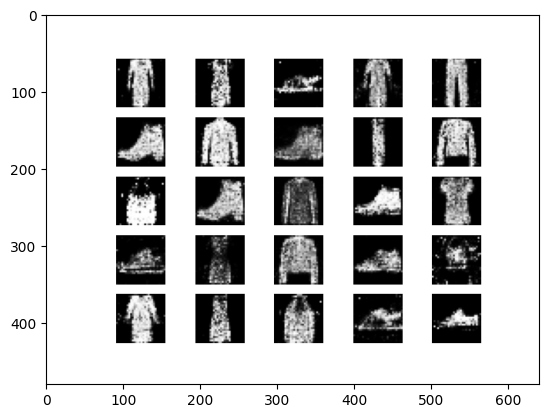

In [15]:
image = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/ativ8_GAN_FASHION_MNIST/output/q9_images/30000.png")
plt.imshow(image)
plt.show()